<a href="https://colab.research.google.com/github/manish284/Convolutional-Neural-Network/blob/master/YOLO_DataPreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import time
import random
import cv2
import numpy as np
import pandas as pd
from skimage import io
import tensorflow as tf
from shutil import copyfile
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
!wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv

--2020-05-25 09:07:30--  https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2258447590 (2.1G) [text/csv]
Saving to: ‘oidv6-train-annotations-bbox.csv’

oidv6-train-annotat 100%[===================>]   2.10G  83.2MB/s    in 18s     

2020-05-25 09:07:48 (119 MB/s) - ‘oidv6-train-annotations-bbox.csv’ saved [2258447590/2258447590]



In [ ]:
!wget https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv

--2020-05-25 09:07:52--  https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv
Resolving datasets.figure-eight.com (datasets.figure-eight.com)... 34.206.186.230, 52.206.250.60
Connecting to datasets.figure-eight.com (datasets.figure-eight.com)|34.206.186.230|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.appen.com/figure_eight_datasets/open-images/train-images-boxable.csv [following]
--2020-05-25 09:07:52--  https://datasets.appen.com/figure_eight_datasets/open-images/train-images-boxable.csv
Resolving datasets.appen.com (datasets.appen.com)... 52.22.189.250, 18.210.87.2, 3.211.204.117, ...
Connecting to datasets.appen.com (datasets.appen.com)|52.22.189.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216137230 (206M) [text/csv]
Saving to: ‘train-images-boxable.csv’

train-images-boxabl 100%[===================>] 206.12M  96.8MB/s    in 2.1s    

2020-05-25 0

In [ ]:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2020-05-25 09:07:56--  https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12011 (12K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  11.73K  --.-KB/s    in 0s      

2020-05-25 09:07:56 (101 MB/s) - ‘class-descriptions-boxable.csv’ saved [12011/12011]



In [ ]:
images_boxable_fname = 'train-images-boxable.csv'
annotations_bbox_fname = 'oidv6-train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [ ]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head(2)

image_name                                          image_url
0  e39871fd9fd74f55.jpg  https://requestor-proxy.figure-eight.com/figur...
1  f18b91585c4d3f3e.jpg  https://requestor-proxy.figure-eight.com/figur...

In [ ]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  000002b66c9c498e  xclick  /m/01g317  ...  0.357812  0.587500  0.325000
1  000002b66c9c498e  xclick  /m/01g317  ...  0.714063  0.782813  0.948438
2  000002b66c9c498e  xclick  /m/01g317  ...  0.434375  0.507812  0.590625
3  000002b66c9c498e  xclick  /m/01g317  ...  0.921875  0.826562  0.925000
4  000002b66c9c498e  xclick  /m/01g317  ...  0.289062  0.348438  0.385938

[5 rows x 21 columns]

In [ ]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [ ]:
#plot bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["image_name"]==img_id+'.jpg']['image_url'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [ ]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (768, 1024, 3)
Coordinates: (496, 382), (854, 720)


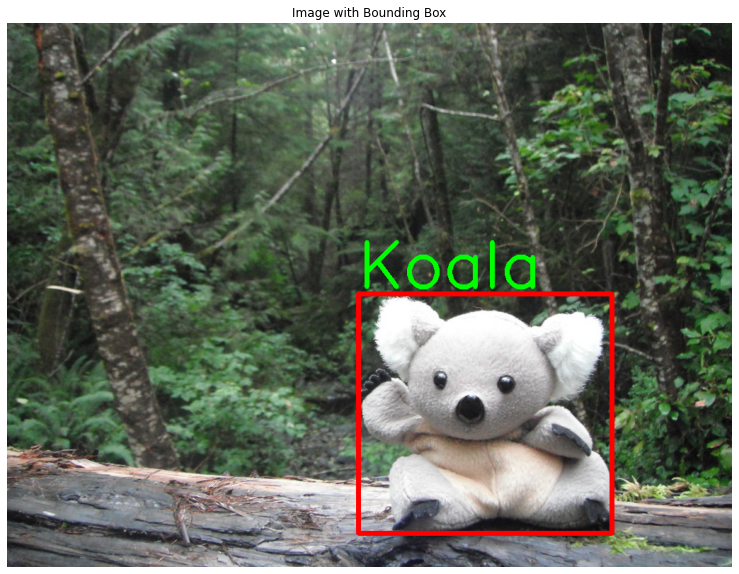

Image: (768, 1024, 3)
Coordinates: (334, 162), (846, 460)


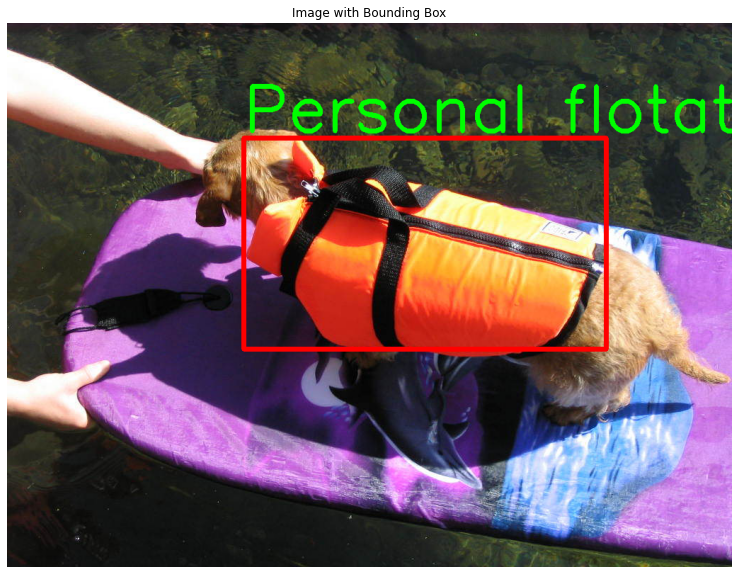

Image: (1024, 1024, 3)
Coordinates: (33, 0), (998, 990)


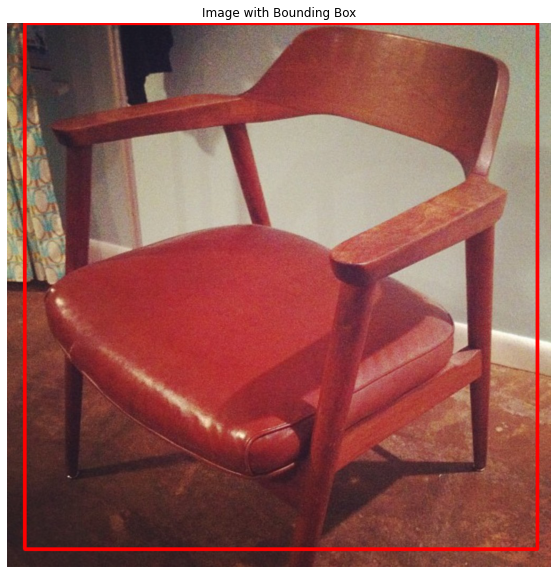

In [ ]:
for img_id in random.sample(list(least_objects_img_ids), 3):
  plot_bbox(img_id)

In [ ]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [ ]:
class_names =['Person', 'Mobile phone', 'Car'] #read_classes("/content/model_data/classes.txt")

In [ ]:
len(class_names)

3

In [ ]:
def getdata(n1):
  n = n1
  mappings = []
  lable  = []
  for i in class_names:
    if [class_descriptions.loc[:,1].str.lower() == str.lower(i)]:
      data = class_descriptions[(class_descriptions[1].str.lower())==str.lower(i)]
      data = data[0].values[0]
      lable.append(data)
      data = annotations_bbox[annotations_bbox['LabelName']==data]
      data = data['ImageID']
      data = np.unique(data)
      data = random.sample(list(data +'.jpg'), n)
      data = images_boxable.loc[images_boxable['image_name'].isin(data)]
      data = data[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()
      mappings.append(data)
  return lable,mappings

In [ ]:
n =50
label_names , mappings = getdata(n)

In [ ]:
#!rm -rf /content/model_data/images
#!rm -rf /content/model_data/test

In [ ]:
#del label_names

In [ ]:
#mappings

In [ ]:
len(mappings)

3

In [ ]:
len(mappings[0])

50

In [ ]:
src ='/content/model_data/images/'
for idx, obj_type in enumerate(class_names):
  n_issues = 0
  # create the directory
  if not os.path.exists(src + obj_type):
    os.mkdir(src + obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(src + obj_type, img_id)
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 0
Images Issues: 0
Images Issues: 0


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/model_data/')

In [ ]:
!mkdir train test

In [ ]:
train_path = '/content/model_data/train/'
test_path = '/content/model_data/test/'

In [ ]:
src = '/content/model_data/images/' 

In [ ]:
for i in range(len(class_names)):
    all_imgs = os.listdir(src + class_names[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each class_names' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(src + class_names[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(src + class_names[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [ ]:
!ls train | wc -l

120


In [ ]:
train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

In [ ]:
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

In [ ]:
for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': i}, 
                                           ignore_index=True)

In [ ]:

len(train_df)

287

In [ ]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

In [ ]:
# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(val_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': i}, 
                                           ignore_index=True)

In [ ]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1024, 768, 3)
Coordinates: (0, 96), (113, 219)
Coordinates: (145, 57), (211, 92)
Coordinates: (349, 88), (412, 124)
Coordinates: (392, 116), (655, 198)
Coordinates: (547, 229), (765, 404)
Coordinates: (101, 81), (196, 168)
Coordinates: (271, 78), (364, 160)


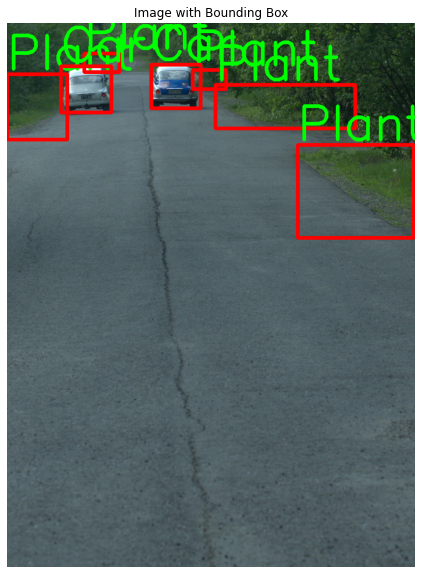

Image: (640, 1024, 3)
Coordinates: (0, 0), (1023, 639)


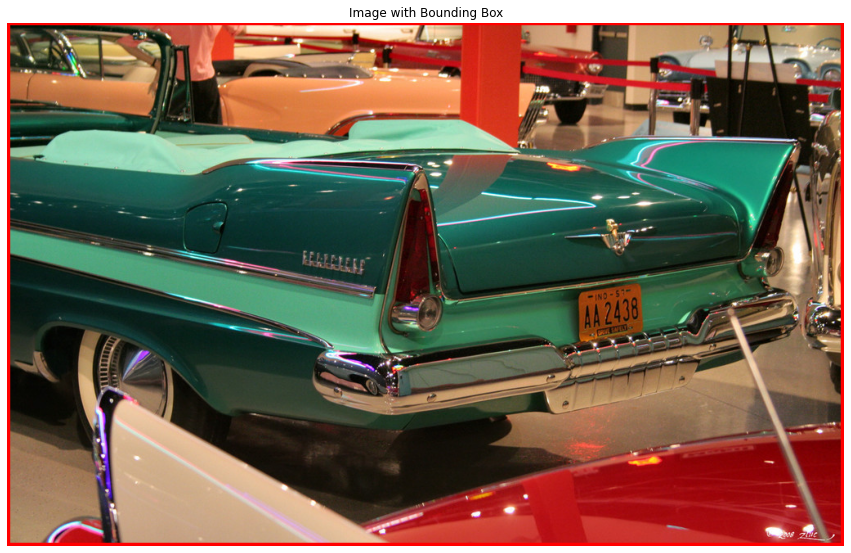

Image: (768, 768, 3)
Coordinates: (36, 129), (732, 697)


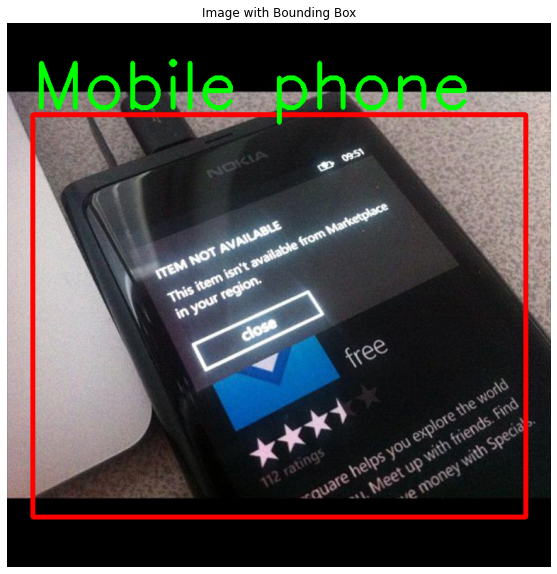

Image: (683, 1024, 3)
Coordinates: (56, 465), (652, 682)
Coordinates: (282, 265), (697, 472)
Coordinates: (331, 328), (853, 590)
Coordinates: (504, 212), (709, 375)
Coordinates: (0, 0), (1023, 334)
Coordinates: (419, 150), (912, 333)
Coordinates: (819, 109), (1023, 289)
Coordinates: (188, 459), (531, 682)
Coordinates: (419, 360), (646, 498)
Coordinates: (431, 264), (641, 365)
Coordinates: (507, 238), (645, 306)


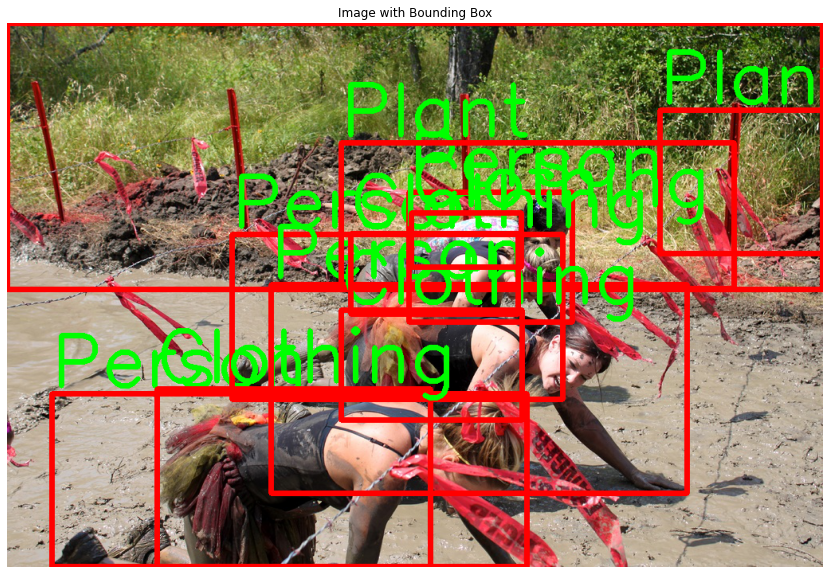

In [ ]:
for img_id in train_img_ids:
  plot_bbox(img_id)

In [ ]:
train_df.to_csv('train.csv')
val_df.to_csv('test.csv')

In [ ]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      path = '/content/drive/My Drive/Colab Notebooks/model_data/train/'
      fileName = os.path.join(path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')

In [ ]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      path = '/content/drive/My Drive/Colab Notebooks/model_data/test/'
      fileName = os.path.join(path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')

In [ ]:
!rm -rf /content/model_data/images